# **HW3-P2: Flow Matching**

We begin our study of *ordinary differential equations* (ODEs) and *stochastic differential equations* (SDEs) in Part 1.
We explore how one can simulate ODEs and SDEs and visualize a number of different examples to better understand the underlying mathematical principles of flows.
In Part 2 we go over a simple Flow Matching example on the [moons dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) from sklearn.
In Part 3 we learn to generate new data using Conditional Flow Matching which is the ultimate desire in generative modeling.

In [1]:
# @title Imports

import numpy as np

import torch
from torch import nn, Tensor

from tqdm.notebook import trange

from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from sklearn.datasets import make_moons, make_circles

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Part 1: **Simulating ODEs and SDEs**

The basis of both ODEs and SDEs are time-dependent *vector fields*, which are functions $u$ defined by $$u:\mathbb{R}^d\times [0,1]\to \mathbb{R}^d,\quad (x,t)\mapsto u_t(x)$$
That is, $u_t(x)$ takes in *where in space we are* ($x$) and *where in time we are* ($t$), and spits out the *direction we should be going in* $u_t(x)$. An ODE is then given by $$d X_t = u_t(X_t)dt, \quad \quad X_0 = x_0.$$
Similarly, an SDE is of the form $$d X_t = u_t(X_t)dt + \sigma_t d W_t, \quad \quad X_0 = x_0,$$
which can be thought of as starting with an ODE given by $u_t$, and adding noise via the *Brownian motion* $(W_t)_{0 \le t \le 1}$. The deterministic term is referred to as the *drift coefficient* $u_t(x)$ and amount of noise added is referred to as the *diffusion coefficient* $\sigma_t$.

In [3]:
class DifferentialEquation:

    def drift_coefficient(self, xt: Tensor, t: Tensor) -> Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
        Returns:
            - drift_coefficient: shape (batch_size, dim)
        """
        return torch.zeros_like(xt)  # Default drift is 0

    def diffusion_coefficient(self, xt: Tensor, t: Tensor) -> Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
        Returns:
            - diffusion_coefficient: shape (batch_size, dim)
        """
        return torch.zeros_like(xt)  # default for ODEs

### **The Simulator**

We may think of ODEs and SDEs as describing the motion of a particle through space. Intuitively, the ODE above says "start at $X_0=x_0$", and move so that your instantaneous velocity is given by $u_t(X_t)$. Similarly, the SDE says "start at $X_0=x_0$", and move so that your instantaneous velocity is given by $u_t(X_t)$ plus a little bit of random noise given scaled by $\sigma_t$. Formally, these trajectories traced out by this intuitive descriptions are said to be *solutions* to the ODEs and SDEs, respectively. Numerical methods for computing these solutions are all essentially based on *simulating*, or *integrating*, the ODE or SDE.

In this section we'll implement the *Euler* and *Euler-Maruyama* numerical simulation schemes for integrating ODEs and SDEs, respectively. Recall from lecture that the Euler simulation scheme corresponds to the discretization
$$d X_t = u_t(X_t) dt  \quad \quad \rightarrow \quad \quad X_{t + h} = X_t + hu_t(X_t),$$
where $h = \Delta t$ is the *step size*. Similarly, the Euler-Maruyama scheme corresponds to the discretization
$$ dX_t = u(X_t,t) dt + \sigma_t d W_t  \quad \quad \rightarrow \quad \quad X_{t + h} = X_t + hu_t(X_t) + \sqrt{h} \sigma_t z_t, \quad z_t \sim N(0,I_d).$$

In [ ]:
class Simulator:
    def __init__(self, diff_eq):
        self.diff_eq = diff_eq

    def step(self, xt: Tensor, t: Tensor, dt: Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
            - dt: time, shape ()
        Returns:
            - nxt: state at time t + dt
        """
        # Formula: X_{t+h} = X_t + h * u_t(X_t)
        drift = self.diff_eq.drift_coefficient(xt, t)
        nxt = xt + drift * dt

        # Formula: ... + sqrt(h) * sigma_t * z_t, where z_t ~ N(0, I)
        diffusion = self.diff_eq.diffusion_coefficient(xt, t)
        noise = torch.randn_like(xt)
        nxt += diffusion * torch.sqrt(dt) * noise

        return nxt

    @torch.no_grad()
    def simulate(self, x: Tensor, ts: Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (batch_size, dim)
            - ts: timesteps, shape (nts,)
        Returns:
            - x_final: final state at time ts[-1], shape (batch_size, dim)
        """
        for t_idx in range(len(ts) - 1):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: Tensor, ts: Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (num_timesteps,)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num_timesteps, dim)
        """
        xs = [x.clone()]
        for t_idx in trange(len(ts) - 1):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

### Example 1: **Brownian Motion**

A Brownian motion is recovered (by definition) by setting $u_t = 0$ and $\sigma_t = \sigma$:
$$ dX_t = \sigma dW_t, \quad \quad X_0 = 0.$$

In [ ]:
class BrownianMotion(DifferentialEquation):
    def __init__(self, sigma: float):
        self.sigma = sigma

    def drift_coefficient(self, xt: Tensor, t: Tensor) -> Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - drift: shape (bs, dim)
        """
        return torch.zeros_like(xt)

    def diffusion_coefficient(self, xt: Tensor, t: Tensor) -> Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - diffusion: shape (bs, dim)
        """
        return torch.full_like(xt, self.sigma)

#### **Question**

- What happens when you vary the value of `sigma`?

  `Your Answer:` **Increasing `sigma` increases the variance (spread) of the trajectories.** Since $\sigma$ acts as a scaling factor for the noise term $dW_t$, a larger `sigma` results in larger random fluctuations at every time step. This causes the particle's path to be more erratic ("noisier") and allows it to travel further away from the origin in the same amount of time. Conversely, a smaller `sigma` constrains the particle closer to its starting point.

In [6]:
# @title Visualization Help

def plot_trajectories_1d(x0: torch.Tensor, simulator: Simulator, timesteps: torch.Tensor, ax = None):
        """
        Graphs the trajectories of a one-dimensional SDE with given initial values (x0) and simulation timesteps (timesteps).
        Args:
            - x0: state at time t, shape (num_trajectories, 1)
            - simulator: Simulator object used to simulate
            - t: timesteps to simulate along, shape (num_timesteps,)
            - ax: pyplot Axes object to plot on
        """
        if ax is None:
            ax = plt.gca()
        trajectories = simulator.simulate_with_trajectory(x0, timesteps) # (num_trajectories, num_timesteps, ...)
        for trajectory_idx in range(trajectories.shape[0]):
            trajectory = trajectories[trajectory_idx, :, 0] # (num_timesteps,)


            ax.plot(timesteps.cpu(), trajectory.cpu())

  0%|          | 0/499 [00:00<?, ?it/s]

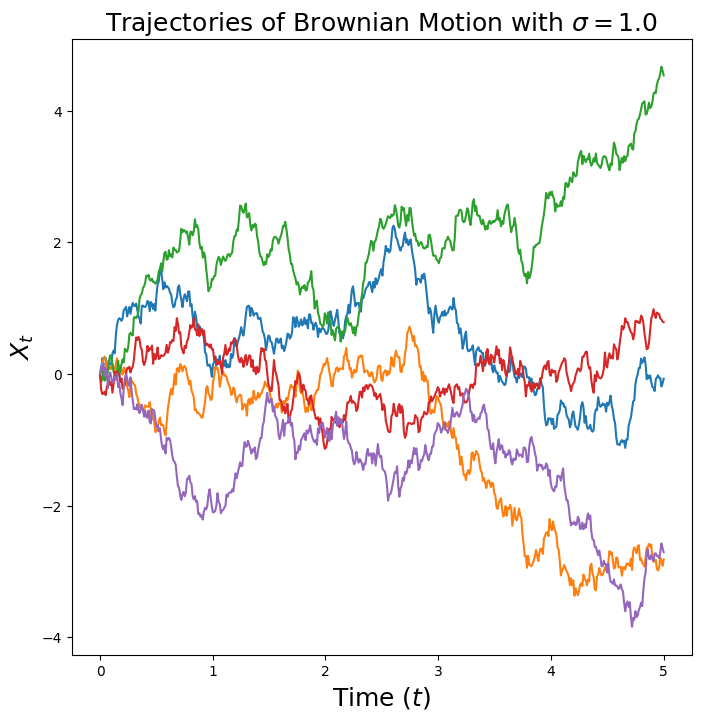

In [15]:
sigma = 1.0
brownian_motion = BrownianMotion(sigma)
simulator = Simulator(brownian_motion)
x0 = torch.zeros(5,1).to(device) # Initial values - let's start at zero
ts = torch.linspace(0.0,5.0,500).to(device) # simulation timesteps

plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.set_title(r'Trajectories of Brownian Motion with $\sigma=$' + str(sigma), fontsize=18)
ax.set_xlabel(r'Time ($t$)', fontsize=18)
ax.set_ylabel(r'$X_t$', fontsize=18)
plot_trajectories_1d(x0, simulator, ts, ax)
plt.show()

### Example 2: **Ornstein-Uhlenbeck Process**

An OU process is given by setting $u_t(X_t) = - \theta X_t$ and $\sigma_t = \sigma$:
$$ dX_t = -\theta X_t\, dt + \sigma\, dW_t, \quad \quad X_0 = x_0.$$

In [ ]:
class OrnsteinUhlenbeck(DifferentialEquation):
    def __init__(self, theta: float, sigma: float):
        self.theta = theta
        self.sigma = sigma

    def drift_coefficient(self, xt: Tensor, t: Tensor) -> Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - drift: shape (bs, dim)
        """
        return -self.theta * xt

    def diffusion_coefficient(self, xt: Tensor, t: Tensor) -> Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - diffusion: shape (bs, dim)
        """
        return torch.full_like(xt, self.sigma)

#### **Question**

-  What do you notice about the convergence of the solutions? Are they converging to a particular point? Or to a distribution? Your answer should be two *qualitative* sentences of the form: "When ($\theta$ or $\sigma$) goes (up or down), we see..."

   `Your Answer:` The solutions converge to a **stationary distribution** centered at zero, rather than a single fixed point.
   1. When **$\theta$ goes up**, we see the trajectories revert more strongly to the mean, resulting in a tighter distribution with lower variance.
   2. When **$\sigma$ goes up**, we see larger random fluctuations, resulting in a wider distribution with higher variance.

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

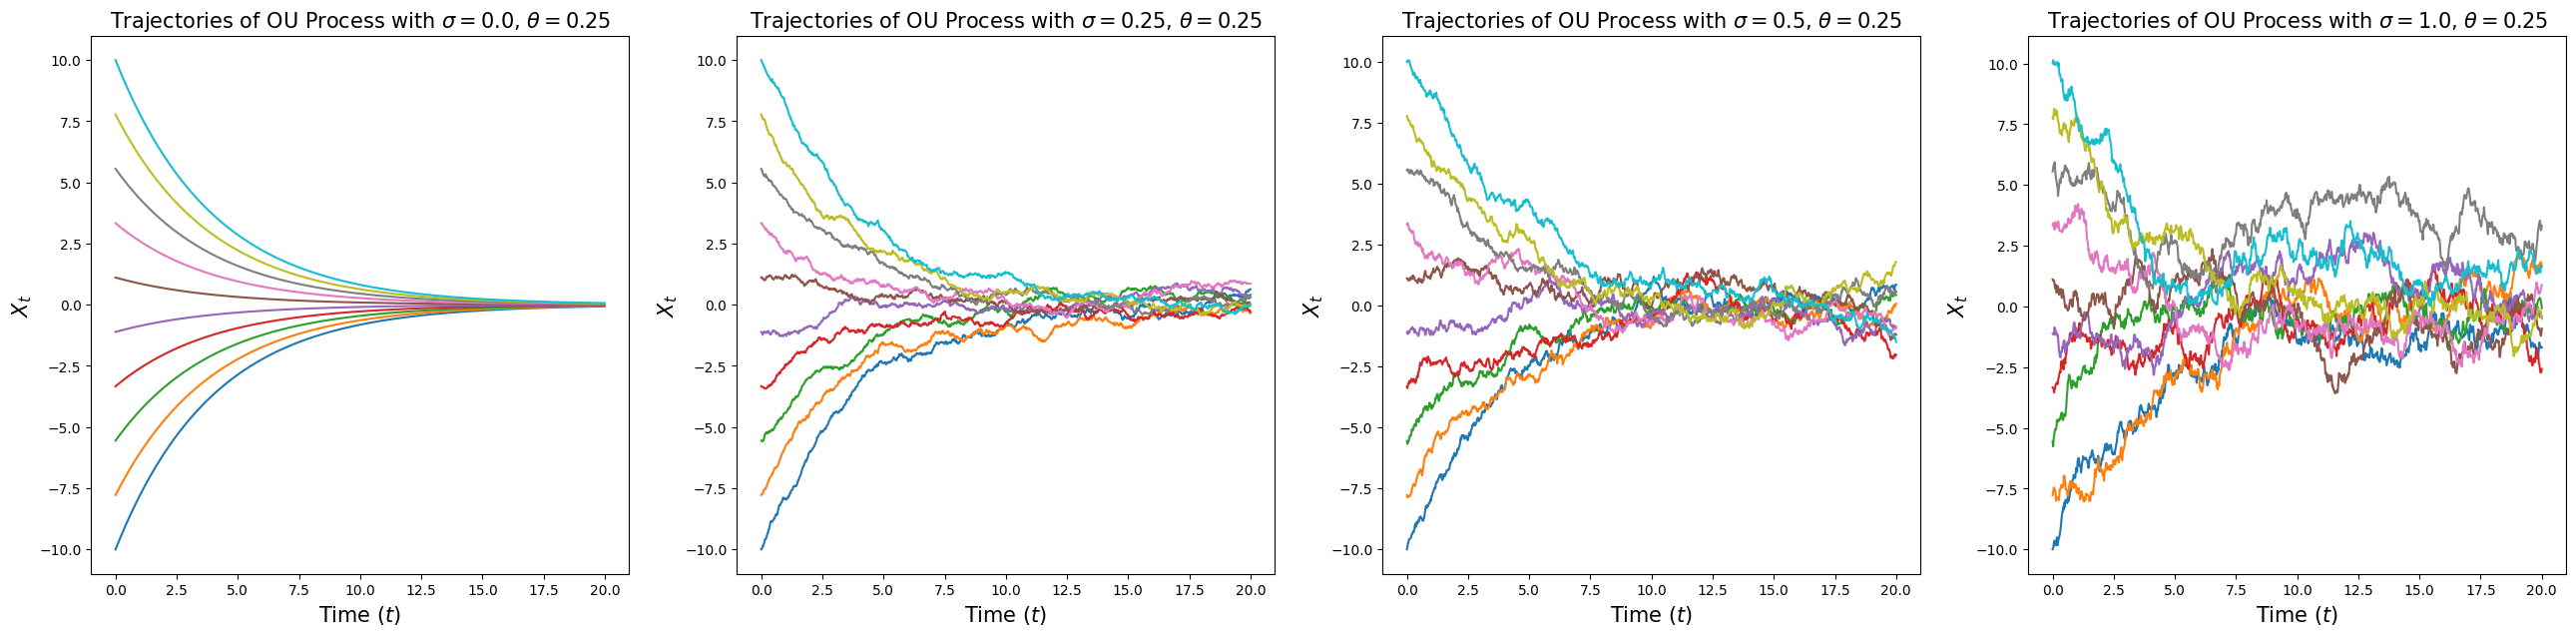

In [17]:
# Try comparing multiple choices side-by-side
thetas_and_sigmas = [
    (0.25, 0.0),
    (0.25, 0.25),
    (0.25, 0.5),
    (0.25, 1.0),
]
simulation_time = 20.0

num_plots = len(thetas_and_sigmas)
fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 7))

for idx, (theta, sigma) in enumerate(thetas_and_sigmas):
    ou_process = OrnsteinUhlenbeck(theta, sigma)
    simulator = Simulator(ou_process)
    x0 = torch.linspace(-10.0,10.0,10).view(-1,1).to(device) # Initial values - let's start at zero
    ts = torch.linspace(0.0,simulation_time,1000).to(device) # simulation timesteps

    ax = axes[idx]
    ax.set_title(f'Trajectories of OU Process with $\\sigma = ${sigma}, $\\theta = ${theta}', fontsize=15)
    ax.set_xlabel(r'Time ($t$)', fontsize=15)
    ax.set_ylabel(r'$X_t$', fontsize=15)
    plot_trajectories_1d(x0, simulator, ts, ax)
plt.show()

## Part 2: **Flow Matching**

Flow matching aims to learn a continuous transformation that morphs a simple noise distribution into a complex data distribution through smooth probability paths.
The core idea is to define a time-dependent vector field that, when integrated over time, transports samples along trajectories from noise to data. Rather than learning arbitrary dynamics, flow matching uses a structured training objective where the network learns to predict pre-defined conditional vector fields that generate straight-line flows between paired noise and data samples.

The mathematical essence involves constructing a probability path $p_t(x)$ connecting distributions $p_0$ (noise) and $p_1$ (data), and learning a vector field $v_t(x)$ whose flow produces this path. During training, pairs of noise and data samples are interpolated linearly, and the network learns to match the simple vector field that points directly from each noise sample to its corresponding data sample. This elegant formulation enables efficient training while guaranteeing that the learned flow reliably maps between the desired distributions when solved numerically.

### **Neural ODE**

To implement the flow model, inherit from `nn.Module` and define a neural network that takes concatenated time and state vectors as input to predict transformation dynamics, then implement both a forward method that computes instantaneous flow directions and a step method that performs numerical integration between time points using ODE solvers like the midpoint method shown here:

\begin{align*}
\Delta t &= t_{\text{end}} - t_{\text{start}}
& k_1 & = f(x_t, t_{\text{start}})
& x_{\text{mid}} &= x_t + \frac{\Delta t}{2} \cdot k_1 \\
 t_{\text{mid}} &= t_{\text{start}} + \frac{\Delta t}{2}
& k_2 &= f(x_{\text{mid}}, t_{\text{mid}})
& x_{t+\Delta t} &= x_t + \Delta t \cdot k_2
\end{align*}

In [ ]:
import torch
import torch.nn as nn
from torch import Tensor

class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        # Network takes [time, state] as input and outputs transformation dynamics
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),  # +1 dimension for time conditioning
            nn.Linear(h, h), nn.ELU(),        # Hidden layers learn complex transformations
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))                # Output matches input dimension for flow

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        """Compute instantaneous flow direction dx/dt at given state x_t and time t"""

        # Ensure t is shaped (batch_size, 1) for concatenation
        if t.dim() == 1:
            t = t.unsqueeze(1)
        
        # If t is a scalar or single value, expand it to match batch size if necessary
        # However, usually t matches x_t's batch dimension in these frameworks.
        
        # Concatenate along the feature dimension (dim=1)
        x_input = torch.cat([x_t, t], dim=1)
        return self.net(x_input)

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        """Numerically integrate the flow from t_start to t_end using midpoint method"""

        # t_start and t_end might be scalars or vectors. We ensure they are compatible with x_t.
        # If they are scalars, we broadcast them to (batch_size, 1).
        batch_size = x_t.shape[0]
        
        if isinstance(t_start, (float, int)):
            t_start = torch.full((batch_size, 1), t_start, device=x_t.device)
        elif t_start.dim() == 1:
            t_start = t_start.unsqueeze(1)
            
        if isinstance(t_end, (float, int)):
            t_end = torch.full((batch_size, 1), t_end, device=x_t.device)
        elif t_end.dim() == 1:
            t_end = t_end.unsqueeze(1)

        dt = t_end - t_start
        
        # k1 = f(x_t, t_start)
        k1 = self.forward(x_t, t_start)
        
        # x_mid = x_t + dt/2 * k1
        x_mid = x_t + (dt / 2) * k1
        t_mid = t_start + (dt / 2)
        
        # k2 = f(x_mid, t_mid)
        k2 = self.forward(x_mid, t_mid)
        
        # x_next = x_t + dt * k2
        x_next = x_t + dt * k2
        
        return x_next

### **Training**

At each step, we create a straight-line path between samples:
$$
  x_t = (1-t) \cdot x_0 + t \cdot x_1
$$
Here $x_0$ is some noise from a simple Gaussian distribution, $x_1$ is the data from the target distribution, and $x_t$ is the interpolated point at time $t \in [0, 1]$.

The model is learning to predict the conditional flow:
$$
  f_{\theta}(x_t, t) \approx u_t(x_t | x_1) = x_1 - x_0
$$

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import trange
from sklearn.datasets import make_moons

def train_flow(flow, n_epochs: int = 10000, batch_size: int = 256):
    """
    Train a flow model using conditional flow matching with linear interpolation paths.
    
    The model learns to predict the vector field that transports samples 
    from noise distribution (x_0) to data distribution (x_1) along straight lines.
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
    
    criterion = nn.MSELoss()
    
    losses = []
    
    flow.train() # Set model to training mode
    
    for epoch in (pbar := trange(n_epochs)):
        
        # generating fresh data every batch to prevent overfitting
        data, _ = make_moons(n_samples=batch_size, noise=0.05)
        x_1 = torch.from_numpy(data).float()
        # Optional: Standardize data to help training stability
        x_1 = (x_1 - x_1.mean(dim=0)) / x_1.std(dim=0)

        x_0 = torch.randn_like(x_1)
        
        # Shape must be (batch_size, 1) for broadcasting
        t = torch.rand(batch_size, 1)
        
        # t is (B, 1), x is (B, D). Broadcasting handles the multiplication.
        x_t = (1 - t) * x_0 + t * x_1
        
        # The time derivative of ((1-t)x0 + t*x1) is (x1 - x0)
        target_v = x_1 - x_0
        
        optimizer.zero_grad()
        predicted_v = flow(x_t, t)
        loss = criterion(predicted_v, target_v)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 100 == 0:
            pbar.set_description(f"Loss: {loss.item():.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss (MSE)")
    plt.title("Flow Matching Training Loss")
    plt.grid(True, alpha=0.3)
    plt.show()

    return losses

  0%|          | 0/10000 [00:00<?, ?it/s]

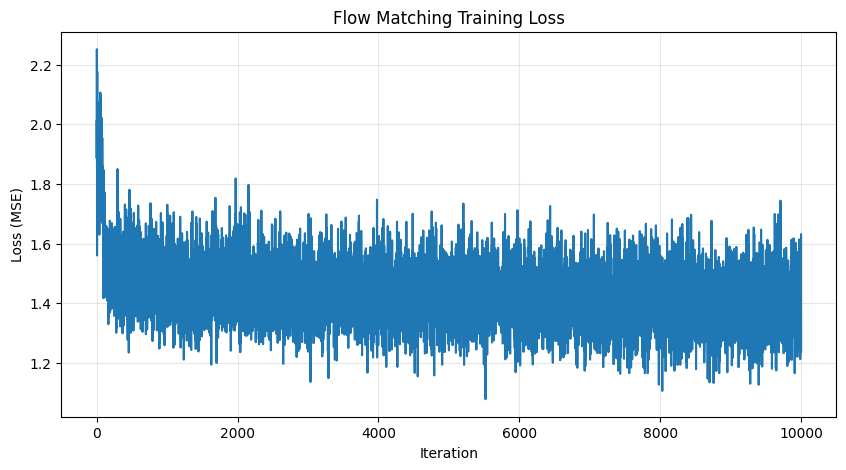

In [20]:
# training
flow = Flow()
loss_values = train_flow(flow)

### **Visualizations**

Let's start with creating a plot of the learned vector field at a specific time step.
Complete the following function.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def plot_vector_field(flow, t=0.5, x_range=(-3, 3), y_range=(-3, 3), n_points=20, ax=None):
    """
    Plot the learned vector field of the flow model at a specific time.

    Args:
        flow: Trained flow model
        t: Time point to visualize (default: 0.5)
        x_range: Tuple of (x_min, x_max) for grid
        y_range: Tuple of (y_min, y_max) for grid
        n_points: Number of grid points in each dimension
        ax: Matplotlib axis to plot on (creates new if None)
    """
    x = np.linspace(x_range[0], x_range[1], n_points)
    y = np.linspace(y_range[0], y_range[1], n_points)
    X, Y = np.meshgrid(x, y)

    # Stack X and Y to get (n_points, n_points, 2), then reshape to (batch, 2)
    grid_points = torch.tensor(
        np.stack([X, Y], axis=-1), dtype=torch.float32).reshape(-1, 2)

    # Create time tensor of shape (batch_size, 1) filled with value t
    time_tensor = torch.full((grid_points.shape[0], 1), t, dtype=torch.float32)

    with torch.no_grad():
        # flow() expects (x_t, t)
        directions = flow(grid_points, time_tensor)

    # directions is (batch, 2), we split into U (x-component) and V (y-component)
    directions_np = directions.numpy()
    U = directions_np[:, 0].reshape(n_points, n_points)
    V = directions_np[:, 1].reshape(n_points, n_points)

    # Create plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Create streamplot for smooth, beautiful vector field visualization
    strm = ax.streamplot(X, Y, U, V,
                         color=np.sqrt(U**2 + V**2),  # Color by magnitude
                         cmap='viridis',              # Color map
                         linewidth=1.5,               # Line thickness
                         arrowstyle='->',            # Arrow style
                         arrowsize=1.5,               # Arrow size
                         density=1.5)                # Streamline density

    # Add colorbar for magnitude
    cbar = plt.colorbar(strm.lines, ax=ax)
    cbar.set_label('Vector Field Magnitude', fontsize=12)

    # Styling
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title(f'Learned Vector Field at t = {t}', fontsize=14, pad=20)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

    # Set nice limits with some padding
    ax.set_xlim(x_range[0] - 0.1, x_range[1] + 0.1)
    ax.set_ylim(y_range[0] - 0.1, y_range[1] + 0.1)

    return ax

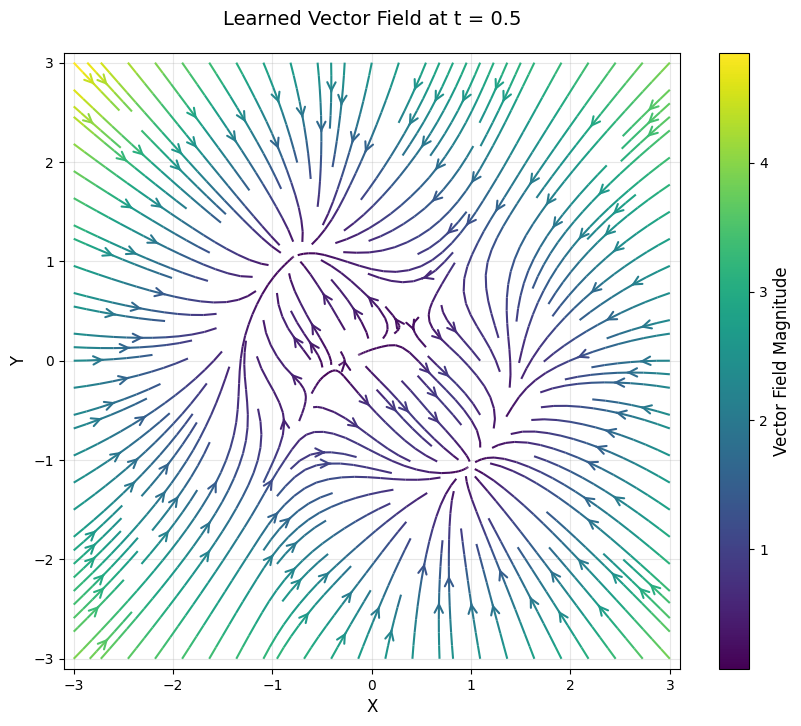

In [24]:
ax = plot_vector_field(flow, t=0.5)  # Single time point

Using the next helper function, plot the flow for different $t$ values.

#### **Question**

- How does the flow change with time $t$?

  `Your Answer:` **The flow evolves from simple transport to complex structural refinement.**
  * **Early ($t \approx 0$):** The vector field is simpler and more uniform, guiding the initial Gaussian noise towards the general region of the data distribution.
  * **Late ($t \to 1$):** The vector field becomes more non-linear and detailed, splitting the flow to guide particles precisely onto the distinct modes (the two separate "moons") of the target geometry.

In [25]:
# @title Vector Field Evolution

def visualize_training_progress(flow, times):
    """
    Visualize how the vector field evolves at different times during the flow.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, t in enumerate(times):
        plot_vector_field(flow, t=t, ax=axes[i])
        # Add sample data points for context
        sample_data = np.random.randn(100, 2) * 0.5
        axes[i].scatter(sample_data[:, 0], sample_data[:, 1],
                       c='red', s=30, alpha=0.6, label='Data samples')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

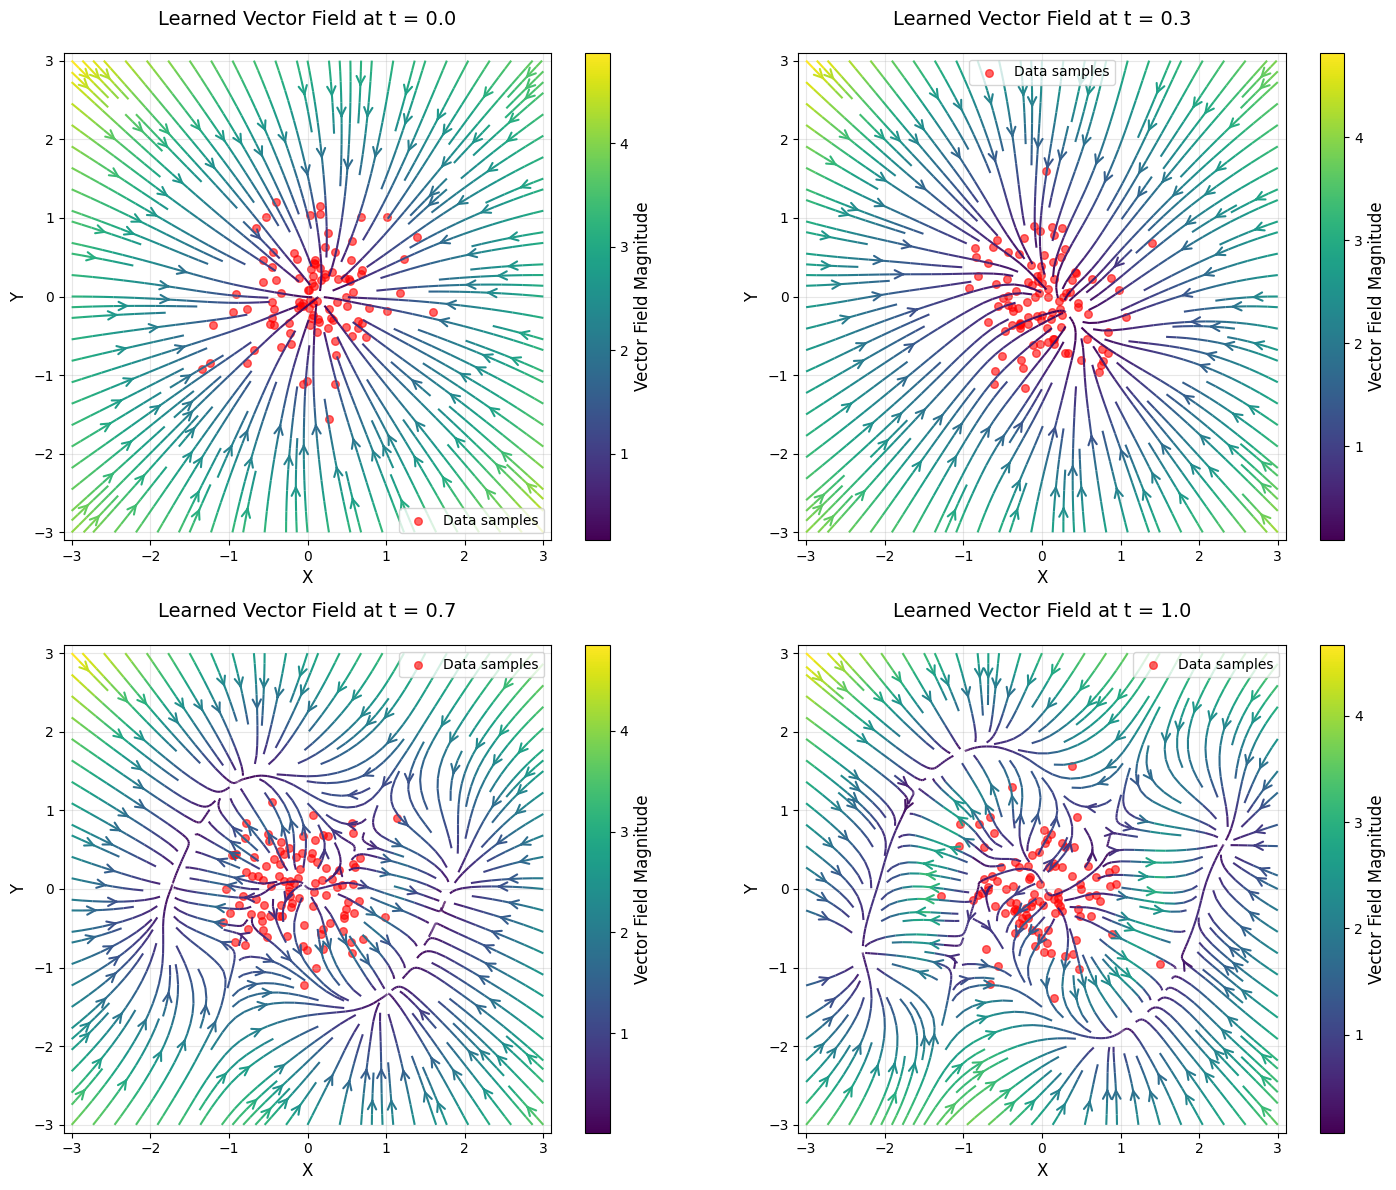

In [26]:
times = [0.0, 0.3, 0.7, 1.0]
visualize_training_progress(flow, times)  # Multiple time points

In [29]:
# @title Visualizer
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image


def create_flow_matching_gif(num_frames: int = 50, num_samples: int = 5000, final_frame_repeat: int = 10):
    # Initialize samples
    x = torch.randn(num_samples, 2)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.tight_layout()

    # Set fixed axis limits
    ax.set_xlim(-3.0, 3.0)
    ax.set_ylim(-3.0, 3.0)

    # Initialize scatter plot
    scatter = ax.scatter(x[:, 0], x[:, 1], s=10)
    title = ax.set_title('t = 0.00')

    # Generate time steps for the actual flow
    time_steps = torch.linspace(0, 1.0, num_frames)

    # Pre-calculate all states
    states = [x.clone()]
    current_x = x.clone()
    for i in range(num_frames - 1):
        # FIX: Use .item() to convert 0-dim tensor to float
        # This triggers the "isinstance(t, float)" logic in your step method
        current_x = flow.step(
            current_x, time_steps[i].item(), time_steps[i + 1].item())
        states.append(current_x.clone())

    # Extend the final state for the desired number of repeats
    extended_states = states + [states[-1]] * final_frame_repeat
    extended_times = list(time_steps.numpy()) + \
        [time_steps[-1].item()] * final_frame_repeat

    # Animation update function
    def update(frame):
        scatter.set_offsets(extended_states[frame].detach().numpy())
        title.set_text(f't = {extended_times[frame]:.2f}')
        return scatter, title

    # Create animation
    anim = FuncAnimation(
        fig,
        update,
        frames=len(extended_states),
        interval=100,
        blit=True
    )

    # Save as GIF
    anim.save('flow_matching.gif', writer=PillowWriter(fps=10))
    plt.close(fig)

    return Image(filename='flow_matching.gif')


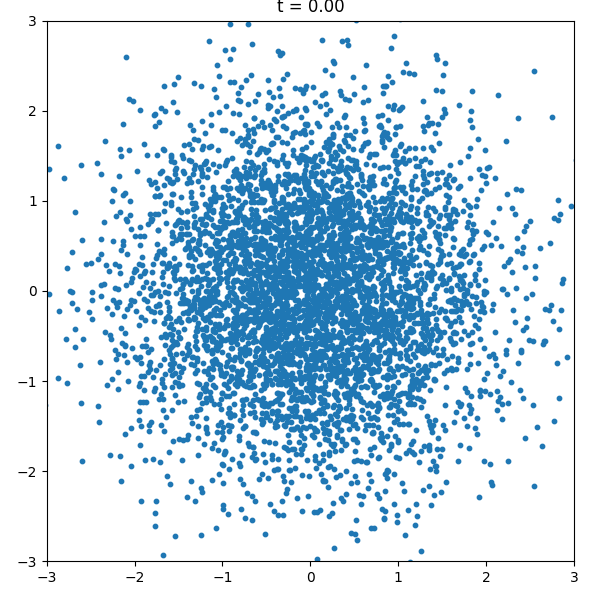

In [30]:
# Create and display the GIF
create_flow_matching_gif()

# Part 3: **Conditional Flow Matching**

Conditional Flows fundamentally transforms the mathematical framework by introducing class-conditioned vector fields that enable targeted sample generation, where instead of learning a single universal transformation from noise to data distribution, the model now learns distinct class-specific probability paths $p_t(x|c)$ through conditional vector fields $v_t(x|c)$ that are modulated by learned class embeddings, allowing each class to discover its own optimal transport dynamics from the base noise distribution to its respective data manifold, which means that during inference by simply switching the class conditioning we can steer the same noise sample to different regions of the data space, effectively enabling controlled generation where the flow becomes a directional transport system that respects the underlying multimodal structure of the data distribution rather than treating it as a monolithic transformation problem.

### **Conditional Flow**

Introduce class embeddings using `nn.Embedding` and incorporate that into the network.

In [ ]:
import torch
import torch.nn as nn
from torch import Tensor


class ConditionalFlow(nn.Module):
    """
    Conditional flow matching model that incorporates class information.
    The network learns class-specific vector fields for each moon.
    """

    def __init__(self, dim: int = 2, h: int = 64, num_classes: int = 2):
        super().__init__()
        # Input: [time, state, class_embedding]
        self.num_classes = num_classes
        self.class_embedding = nn.Embedding(
            num_classes, 4)  # Learn class embeddings

        self.net = nn.Sequential(
            nn.Linear(dim + 1 + 4, h),  # +1 for time, +4 for class embedding
            nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)  # Output flow direction
        )

    def forward(self, x_t: Tensor, t: Tensor, class_labels: Tensor) -> Tensor:
        """Compute flow direction conditioned on class labels"""

        # class_labels shape: (batch_size,) -> embeddings: (batch_size, 4)
        class_emb = self.class_embedding(class_labels)

        # Ensure t is shaped (batch_size, 1) for concatenation
        if t.dim() == 1:
            t = t.unsqueeze(1)

        # x_t: (batch, dim), t: (batch, 1), class_emb: (batch, embedding_dim)
        x_input = torch.cat([x_t, t, class_emb], dim=1)

        return self.net(x_input)

### **Training**

This time, we'll generate data but keep the labels as well.
The labels will allow us to perform conditional generation.
Moreover, here we use the generic `data_generator` function which operates exactly like the `make_moons` dataset.
This change allows us to analyze other datasets such as `make_circles`.

In [ ]:
def train_conditional_flow(flow, data_generator, n_epochs: int = 10000, batch_size: int = 256):
    """
    Train conditional flow matching where each moon follows its own transformation path
    """

    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

    criterion = nn.MSELoss()

    losses = []
    
    flow.train()

    for epoch in (pbar := trange(n_epochs)):

        # data_generator behaves like make_moons/make_circles
        data, labels_np = data_generator(n_samples=batch_size, noise=0.05)
        x_1 = torch.from_numpy(data).float()
        labels = torch.from_numpy(labels_np).long() # Ensure labels are LongTensor for embedding

        # Optional: Standardize if necessary (omitted here to keep simple)

        # Standard Gaussian noise is used as the base for all classes
        x_0 = torch.randn_like(x_1)

        t = torch.rand(batch_size, 1)

        x_t = (1 - t) * x_0 + t * x_1

        # Target direction is the straight line from noise to data
        target_v = x_1 - x_0
        
        optimizer.zero_grad()
        # Pass labels to the conditional flow model
        predicted_v = flow(x_t, t, labels)
        
        loss = criterion(predicted_v, target_v)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 100 == 0:
            pbar.set_description(f"Loss: {loss.item():.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss (MSE)")
    plt.title("Conditional Flow Matching Training Loss")
    plt.grid(True, alpha=0.3)
    plt.show()

    return losses

  0%|          | 0/5000 [00:00<?, ?it/s]

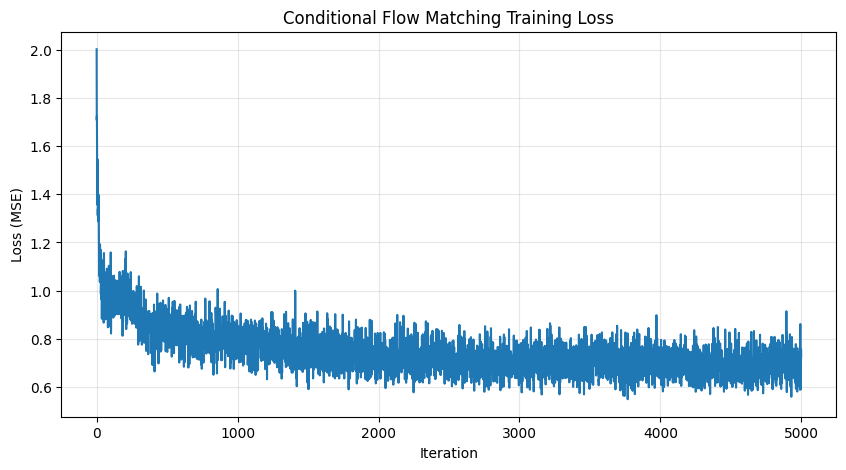

In [33]:
cflow = ConditionalFlow(dim=2, h=64, num_classes=2)
loss_history = train_conditional_flow(cflow, make_moons, n_epochs=5000)

### **Visualization**

Make sure your models learn the correct data distribution.

In [34]:
# @title Visualization Help

def plot_conditional_vector_field(flow, class_label=0, t=0.5, x_range=(-2, 2), y_range=(-2, 2), n_points=20, ax=None):
    """
    Plot vector field for a specific class
    """
    x = np.linspace(x_range[0], x_range[1], n_points)
    y = np.linspace(y_range[0], y_range[1], n_points)
    X, Y = np.meshgrid(x, y)

    grid_points = torch.FloatTensor(np.stack([X.ravel(), Y.ravel()], axis=1))
    time_tensor = torch.full((grid_points.shape[0], 1), t)
    class_tensor = torch.full((grid_points.shape[0],), class_label, dtype=torch.long)

    with torch.no_grad():
        directions = flow(grid_points, time_tensor, class_tensor).numpy()

    U = directions[:, 0].reshape(X.shape)
    V = directions[:, 1].reshape(Y.shape)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    strm = ax.streamplot(X, Y, U, V,
                        color=np.sqrt(U**2 + V**2),
                        cmap='viridis', linewidth=1.5, arrowsize=1.5, density=1.5)

    # Add colorbar only if we're creating a new figure
    if ax is None:
        plt.colorbar(strm.lines, ax=ax).set_label('Flow Magnitude')
    else:
        # For subplots, we'll add a colorbar outside the loop
        pass

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Conditional Vector Field - Class {class_label} at t = {t}')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

    return ax, strm

def compare_conditional_flows(flow, data_generator):
    """
    Compare vector fields for both classes side by side
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Generate some sample data to overlay
    x_data, y_labels = data_generator(200, noise=0.05)
    class_0_mask = y_labels == 0
    class_1_mask = y_labels == 1

    # Plot class 0
    ax1, strm1 = plot_conditional_vector_field(flow, class_label=0, t=0.5, ax=ax1)
    ax1.scatter(x_data[class_0_mask, 0], x_data[class_0_mask, 1],
               c='red', s=50, alpha=0.7, label='Class 0 Data')
    ax1.legend()

    # Plot class 1
    ax2, strm2 = plot_conditional_vector_field(flow, class_label=1, t=0.5, ax=ax2)
    ax2.scatter(x_data[class_1_mask, 0], x_data[class_1_mask, 1],
               c='blue', s=50, alpha=0.7, label='Class 1 Data')
    ax2.legend()

    # Add colorbars for both subplots
    plt.colorbar(strm1.lines, ax=ax1).set_label('Flow Magnitude')
    plt.colorbar(strm2.lines, ax=ax2).set_label('Flow Magnitude')

    plt.tight_layout()
    plt.show()


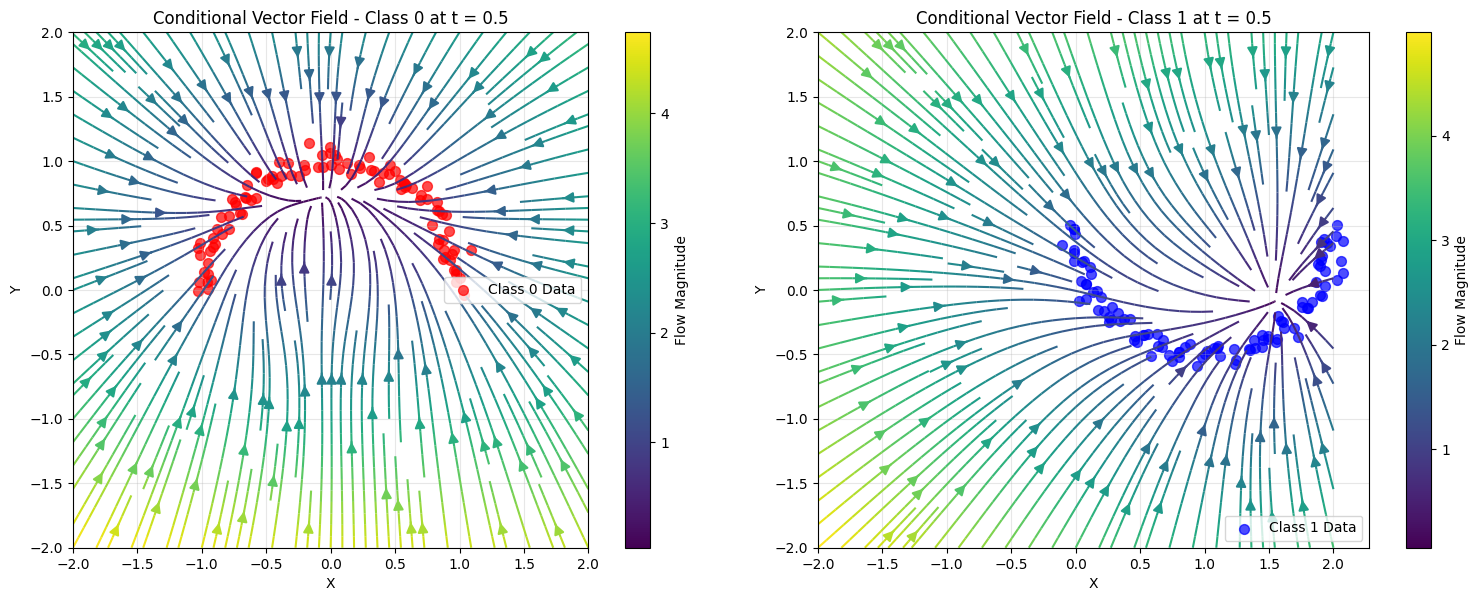

In [35]:
compare_conditional_flows(cflow, make_moons)

Repeat the same steps for the `make_circles` dataset.

  0%|          | 0/5000 [00:00<?, ?it/s]

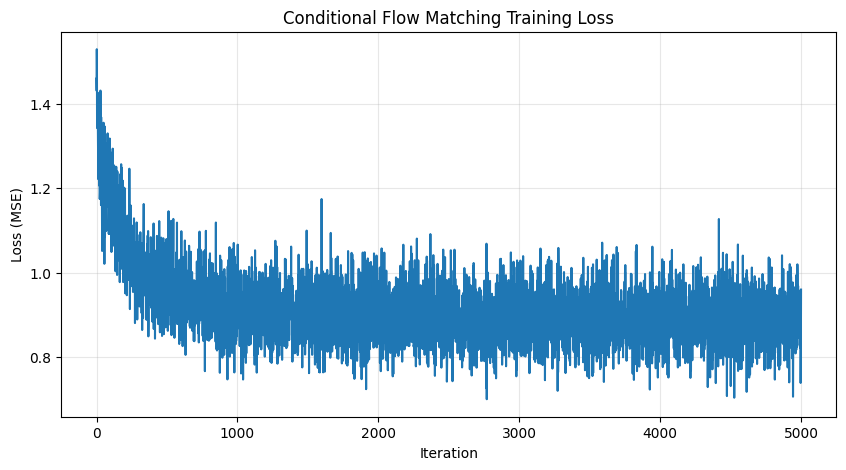

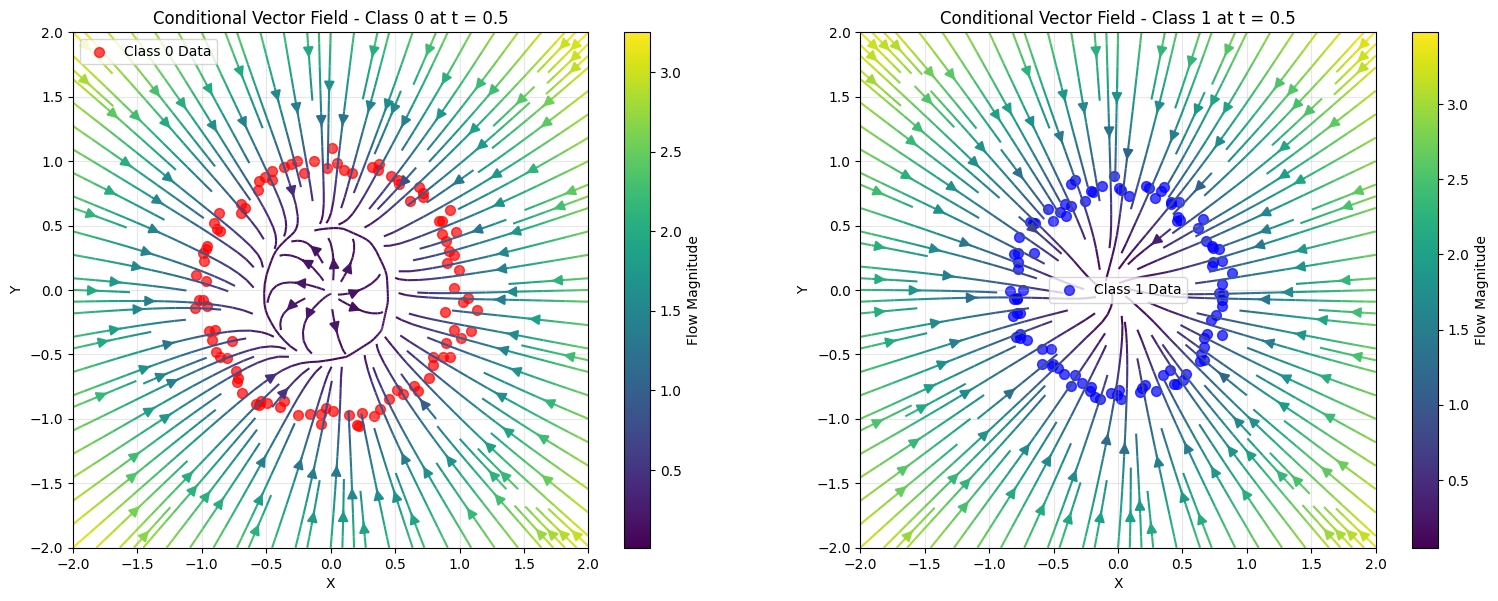

In [36]:
cflow = ConditionalFlow(dim=2, h=64, num_classes=2)
loss_history = train_conditional_flow(cflow, make_circles, n_epochs=5000)
compare_conditional_flows(cflow, make_circles)

### **Questions**

- How is Conditional Flow Matching fundamentally different from normal Flow Matching?

  `Your Answer:` **Conditional Flow Matching allows for controlled generation by learning distinct vector fields for each class.**
  While normal Flow Matching learns a single marginal vector field that maps noise to the entire data distribution indiscriminately, Conditional Flow Matching introduces class labels as inputs (via embeddings). This allows the model to learn specific probability paths $v_t(x|c)$ for each class, enabling us to choose exactly which mode of the data (e.g., which moon) to generate during inference.

- Briefly explain how **Optimal Transport Flow Matching** can improve our results.

  `Your Answer:` **Optimal Transport improves results by minimizing the transport distance and straightening the paths.**
  Instead of pairing noise samples ($x_0$) and data samples ($x_1$) randomly (independent coupling), Optimal Transport pairs them based on proximity (e.g., matching a noise point to the nearest data point). This eliminates crossing paths and reduces the variance of the target vector field, making the flow easier for the network to learn and more stable to integrate numerically.